In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [62]:
df = pd.read_csv('day.csv')

In [63]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


> "cnt" column is our target column

In [64]:
df.shape

(730, 16)

In [65]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


## Data Cleaning 

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [67]:
# we don't need 'instance' additional index
# we don't need exact dates as yr, month and day column exist
# since we have total count, "casual" and "registered" count can be dropped 
df.drop(columns=['instant','dteday','casual','registered'],inplace=True)

In [68]:
df.drop_duplicates(inplace=True)
df.shape # no duplicates found

(730, 12)

In [69]:
# checking null rows
df.isna().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

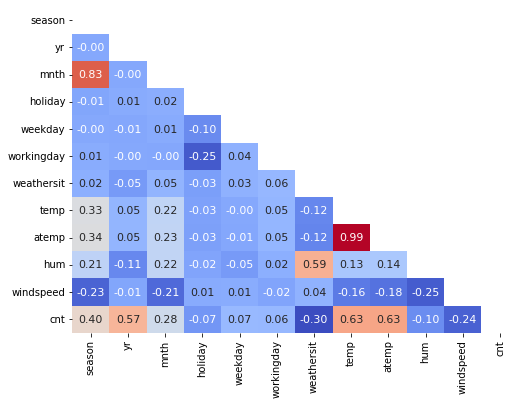

In [70]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm',
            mask=mask,cbar=False,annot_kws={"size":11})

plt.show()

- positively and highly correlated columns with target ( count of bikes )  - 
   - season 
   - year
   - temp
   - atemp ( feels like temp )
- Negetively correlated columns with target - 
   - weather situation
   - windspeed

let's split data into categorical and numerical variables for analysis 

In [71]:
df.iloc[:,7:]#.columns.to_list()

,temp,atemp,hum,windspeed,cnt
0,14.110847,18.18125,80.5833,10.749882,985
1,14.902598,17.68695,69.6087,16.652113,801
2,8.050924,9.47025,43.7273,16.636703,1349
3,8.200000,10.60610,59.0435,10.739832,1562
4,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...
725,10.420847,11.33210,65.2917,23.458911,2114
726,10.386653,12.75230,59.0000,10.416557,3095
727,10.386653,12.12000,75.2917,8.333661,1341
728,10.489153,11.58500,48.3333,23.500518,1796


In [72]:
categorical_cols = df.iloc[:,:7].columns.to_list() # first 7 columns are categorical
print(f"Categorical Columns   : {categorical_cols}")
numerical_cols = df.iloc[:,7:].columns.to_list() # rest of them are numeric 
print(f"Numeric Columns       : {numerical_cols}")


Categorical Columns   : ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
Numeric Columns       : ['temp', 'atemp', 'hum', 'windspeed', 'cnt']


Visualising Numeric Variables using a pairplot

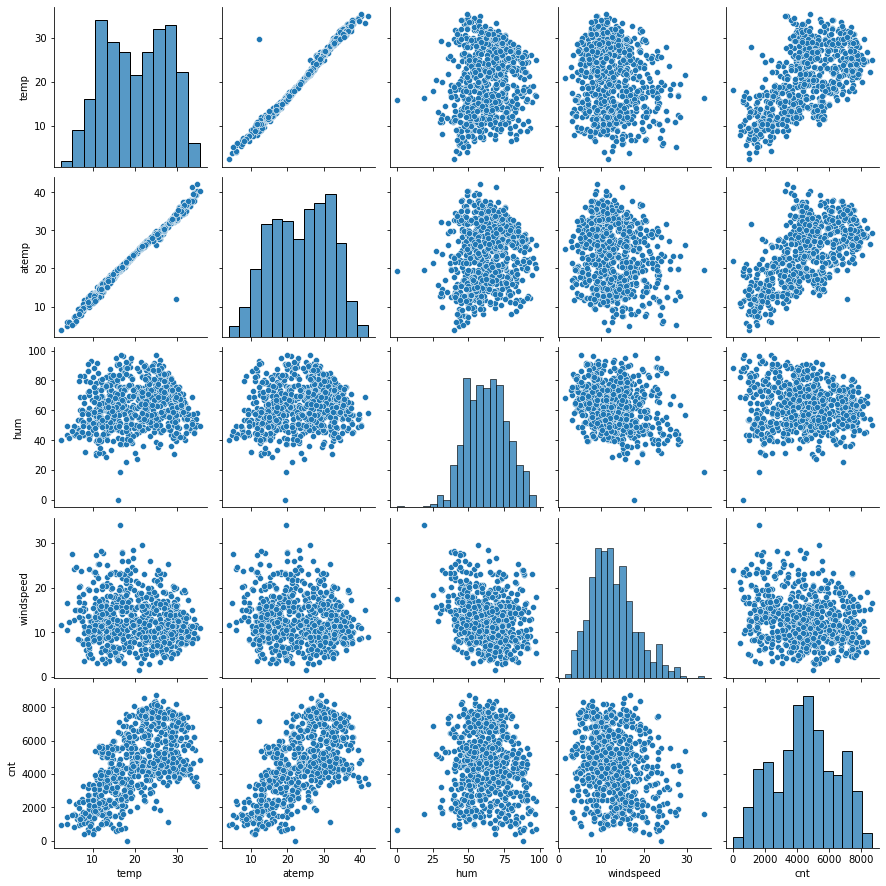

In [73]:

sns.pairplot(data=df,vars=numerical_cols)

- atemp ("feels like" temperature) and target are positively correlated ( also seen in corr matrix)
- temp and target are also correlated 
- Hence we can use a linear model 

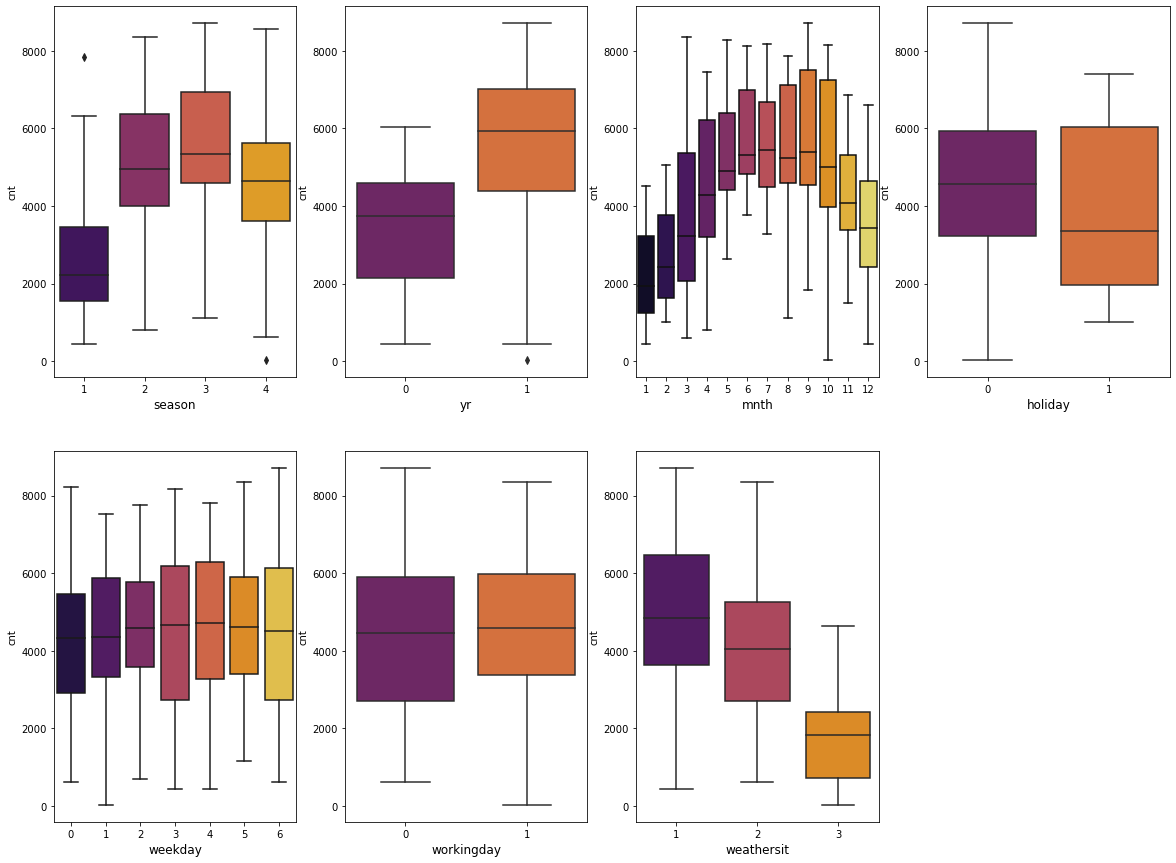

In [74]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(categorical_cols, start=1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=col, y='cnt', data=df,palette='inferno')
    plt.xlabel(col, fontsize=12) 
plt.show()

- "Season"  : summer and fall  have high medians  
- "Year"    : 2019 has higher count than 2018 
- "Month"   : as summer and fall have high counts , months starting April upto November have high counts
- "Holiday" : Workday has higher count 
- Weather situation  : People prefer bikes if weather is Clear, Few clouds, Partly cloudy, Partly cloudy 

### for each variable , let's create columns for each level

In [75]:
for i in categorical_cols:
   df[i] = df[i].astype(str)

In [76]:
dummy = pd.get_dummies(df[categorical_cols] ,drop_first=True)

In [77]:
dummy

,season_2,season_3,season_4,yr_1,mnth_10,mnth_11,mnth_12,mnth_2,mnth_3,mnth_4,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
726,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,1,0
727,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
728,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
bike_df = pd.concat([dummy,df[numerical_cols]],axis=1)
bike_df

,season_2,season_3,season_4,yr_1,mnth_10,mnth_11,mnth_12,mnth_2,mnth_3,mnth_4,...,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,temp,atemp,hum,windspeed,cnt
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,14.110847,18.18125,80.5833,10.749882,985
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,14.902598,17.68695,69.6087,16.652113,801
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,8.050924,9.47025,43.7273,16.636703,1349
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,8.200000,10.60610,59.0435,10.739832,1562
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,0,0,1,0,0,1,0,0,0,...,0,0,1,1,0,10.420847,11.33210,65.2917,23.458911,2114
726,0,0,0,1,0,0,1,0,0,0,...,1,0,1,1,0,10.386653,12.75230,59.0000,10.416557,3095
727,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,10.386653,12.12000,75.2917,8.333661,1341
728,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,10.489153,11.58500,48.3333,23.500518,1796


In [84]:
from sklearn.model_selection import train_test_split

X = bike_df.drop(columns='cnt')
y = bike_df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [85]:
# Scaling numeric features and capping max range to upto 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols]) 

KeyError: "['cnt'] not in index"

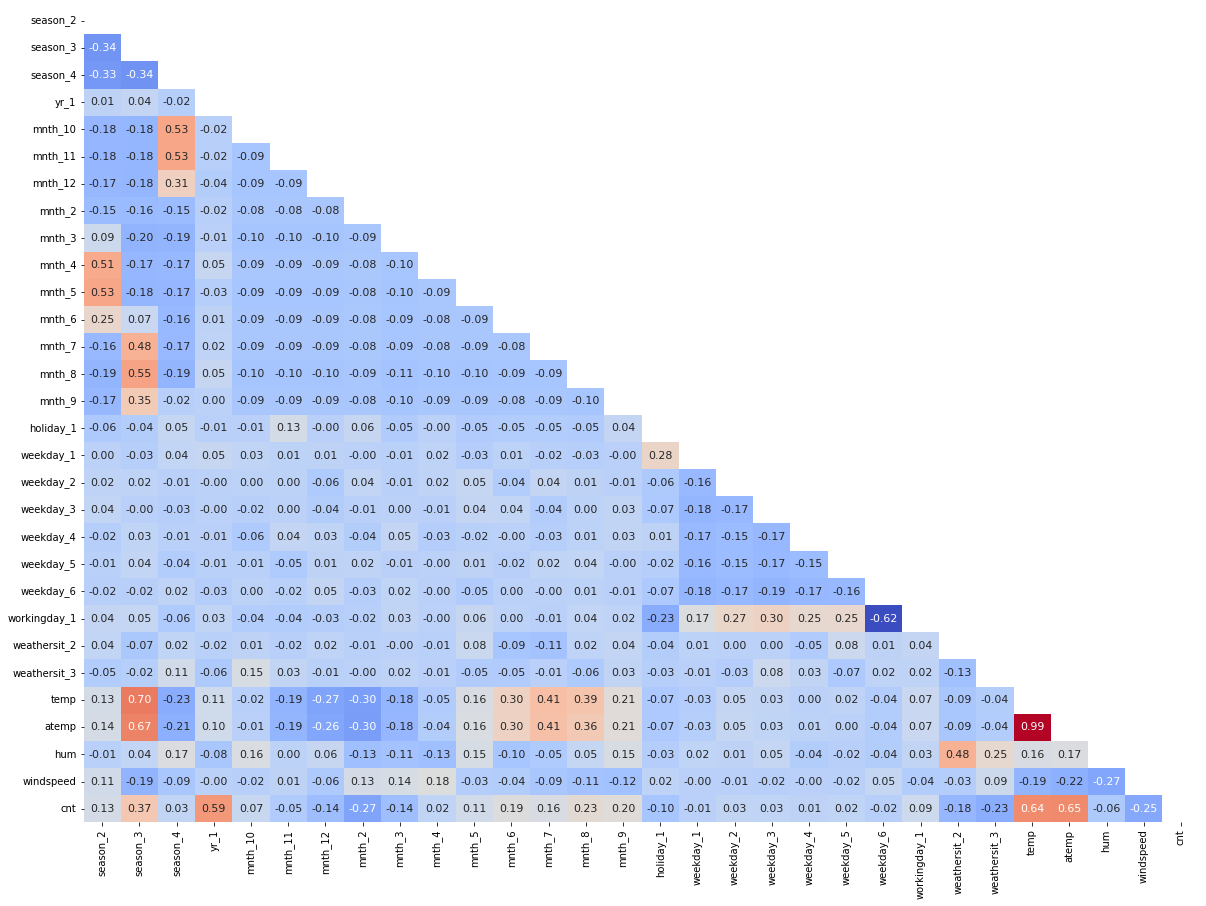

In [83]:
mask = np.triu(np.ones_like(train.corr(), dtype=bool))

plt.figure(figsize=(20,15))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap='coolwarm',
            mask=mask,cbar=False,annot_kws={"size":11})

plt.show()